<a href="https://colab.research.google.com/github/mmender2/Auction-House-React/blob/main/Aunanlytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
#!pip install catboost
#!pip install numpy
#!pip install pandas

# Imports of Libraries

In [244]:
import os, sys, time, copy
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import manifold
from sklearn import decomposition
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



# Load Data and Take Quick Look at Data

In [245]:
train = pd.read_csv('/content/drive/MyDrive/au_train.csv')
test = pd.read_csv('/content/drive/MyDrive/au_test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (32561, 15)
Test shape: (16281, 15)


In [246]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Summary Function for Data Analysis

In [247]:
def summary(df):
    print(f"Data shape: {df.shape}")
    print("\nSummary of columns missing values")
    print(df[df.isna().sum()[df.isna().sum() > 0].index].dtypes)
    print()
    summ = pd.DataFrame(df.dtypes, columns=['Data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values

    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values

    return summ

Prints the shape of the DataFrame (df.shape), which gives the number of rows and columns in the DataFrame.

Prints a summary of columns with missing values. It identifies the columns that have missing values (df.isna().sum()[df.isna().sum() > 0].index), retrieves their data types, and prints them.

Creates a summary DataFrame (summ) that contains information about the data types, missing values, and unique values for each column in the DataFrame.

Computes the number of missing values (df.isnull().sum().values) and the percentage of missing values relative to the total number of rows in the DataFrame (df.isnull().sum().values / len(df) * 100), and adds these values to the summary DataFrame (summ).

Computes the number of unique values in each column (df.nunique().values) and adds this information to the summary DataFrame (summ).

Creates another DataFrame (desc) by using the describe method on the DataFrame, which provides various statistics such as count, mean, standard deviation, minimum, first quartile (25th percentile), median (second quartile or 50th percentile), and third quartile (75th percentile) for numeric columns.

Transposes the DataFrame and assigns it to desc.

Adds the minimum, maximum, and quartile values from the desc DataFrame to the summary DataFrame (summ).

Returns the summary DataFrame (summ).

In [248]:
summary(train)

Data shape: (32561, 15)

Summary of columns missing values
Series([], dtype: object)



,Data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
age,int64,0,0.0,73,17.0,90.0,28.0,37.0,48.0
workclass,object,0,0.0,9,NaN,NaN,NaN,NaN,NaN
fnlwgt,int64,0,0.0,21648,12285.0,1484705.0,117827.0,178356.0,237051.0
education,object,0,0.0,16,NaN,NaN,NaN,NaN,NaN
education-num,int64,0,0.0,16,1.0,16.0,9.0,10.0,12.0
marital-status,object,0,0.0,7,NaN,NaN,NaN,NaN,NaN
occupation,object,0,0.0,15,NaN,NaN,NaN,NaN,NaN
relationship,object,0,0.0,6,NaN,NaN,NaN,NaN,NaN
race,object,0,0.0,5,NaN,NaN,NaN,NaN,NaN
sex,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN


# Identify Numerical and Categorical Variables

In [249]:
# select numerical and categorical features
num_cols = test.select_dtypes(include=np.number).columns.tolist()
cat_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Id' in cat_cols:
    cat_cols.remove('Id')
print(f"Total numerical features: {len(num_cols)}")
print(f"Total categorical features: {len(cat_cols)}")

Total numerical features: 6
Total categorical features: 9


        class  pct (%)
 <=50K  24720   75.919
 >50K    7841   24.081 



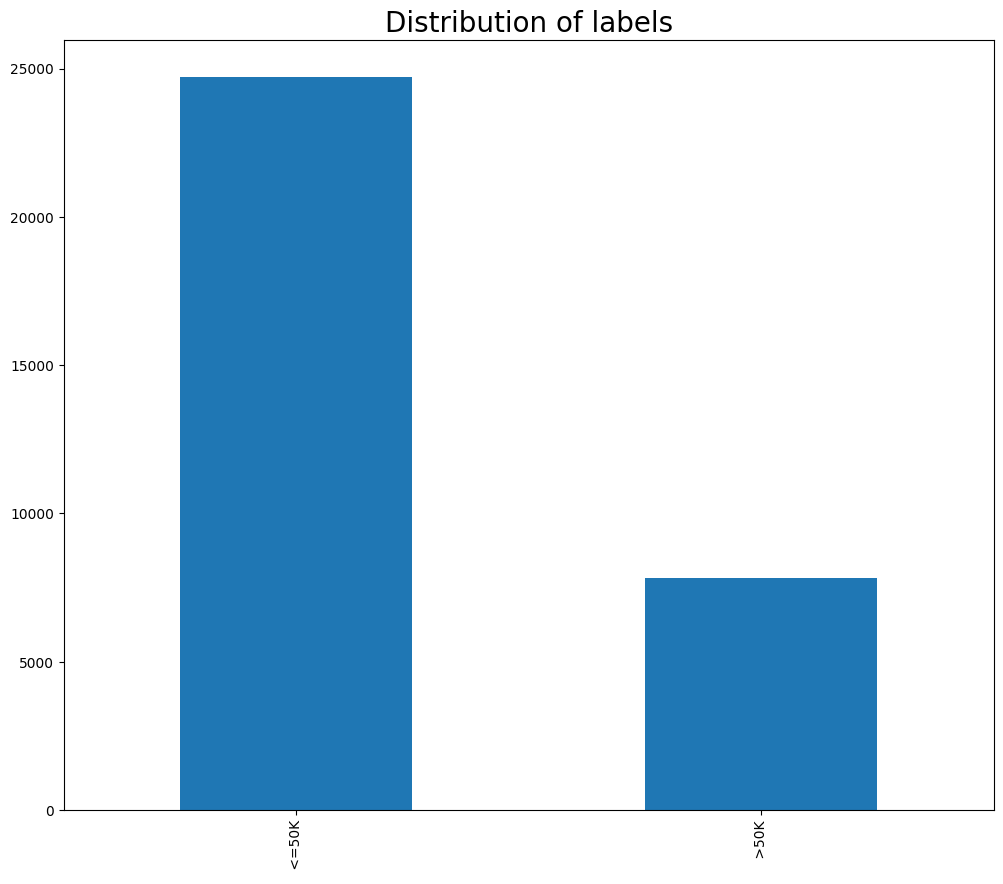

In [250]:
df = pd.DataFrame(train['class'].value_counts())
df['pct (%)'] = np.round((train['class'].value_counts()/train.shape[0]).values * 100, 4)
print(df, "\n")
plt.title('Distribution of labels', fontsize=20)
train['class'].value_counts().plot(kind='bar');

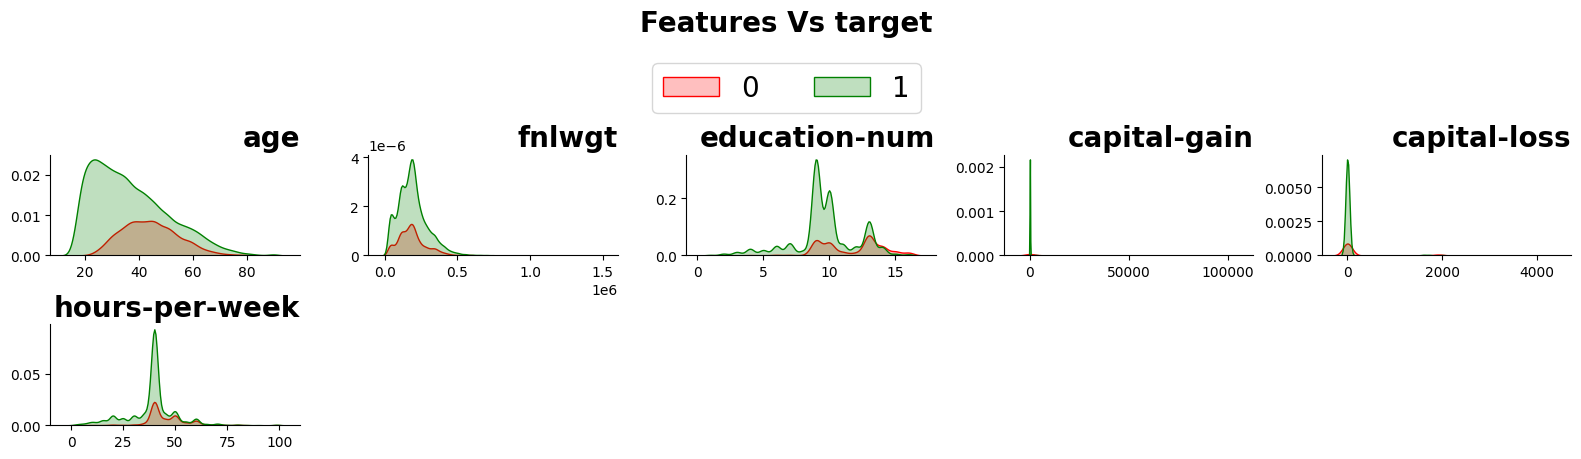

In [251]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(11, 5, idx + 1)
    sns.kdeplot(
        data=train, hue='class', fill=True,
        x=col, palette=['green', 'red'], legend=False
    )

    ax.set_ylabel(''); ax.spines['top'].set_visible(False)
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', weight='bold', fontsize=20)

fig.suptitle(f'Features Vs target\n\n\n', ha='center', fontweight='bold', fontsize=20)
fig.legend([0, 1], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=20, ncol=3)
plt.tight_layout()
plt.show()

This plot provides a visual representation of the distribution of numerical features in relation to the target variable. It helps in understanding the relationship between the features and the target, and can provide insights into how different feature values may be associated with different target variable values.

In [252]:
def visualize_outliers(df1, num_cols=num_cols):
    cols = 4
    rows = len(num_cols) // cols + 1
    plt.figure(figsize=(10,20))
    for idx, feature in enumerate(num_cols):
        ax = plt.subplot(rows, cols, idx+1)
        sns.boxplot(
            data=df1, x='class', y=feature
        )
        ax.set_title(feature)
#         ax.set_xticks([0, 1], ['Faulty', 'Un-Faulty'])
        ax.set_ylabel("Distribution")

    # plt.suptitle('Checking for outliers', fontsize=14)
    plt.tight_layout()
    plt.show()

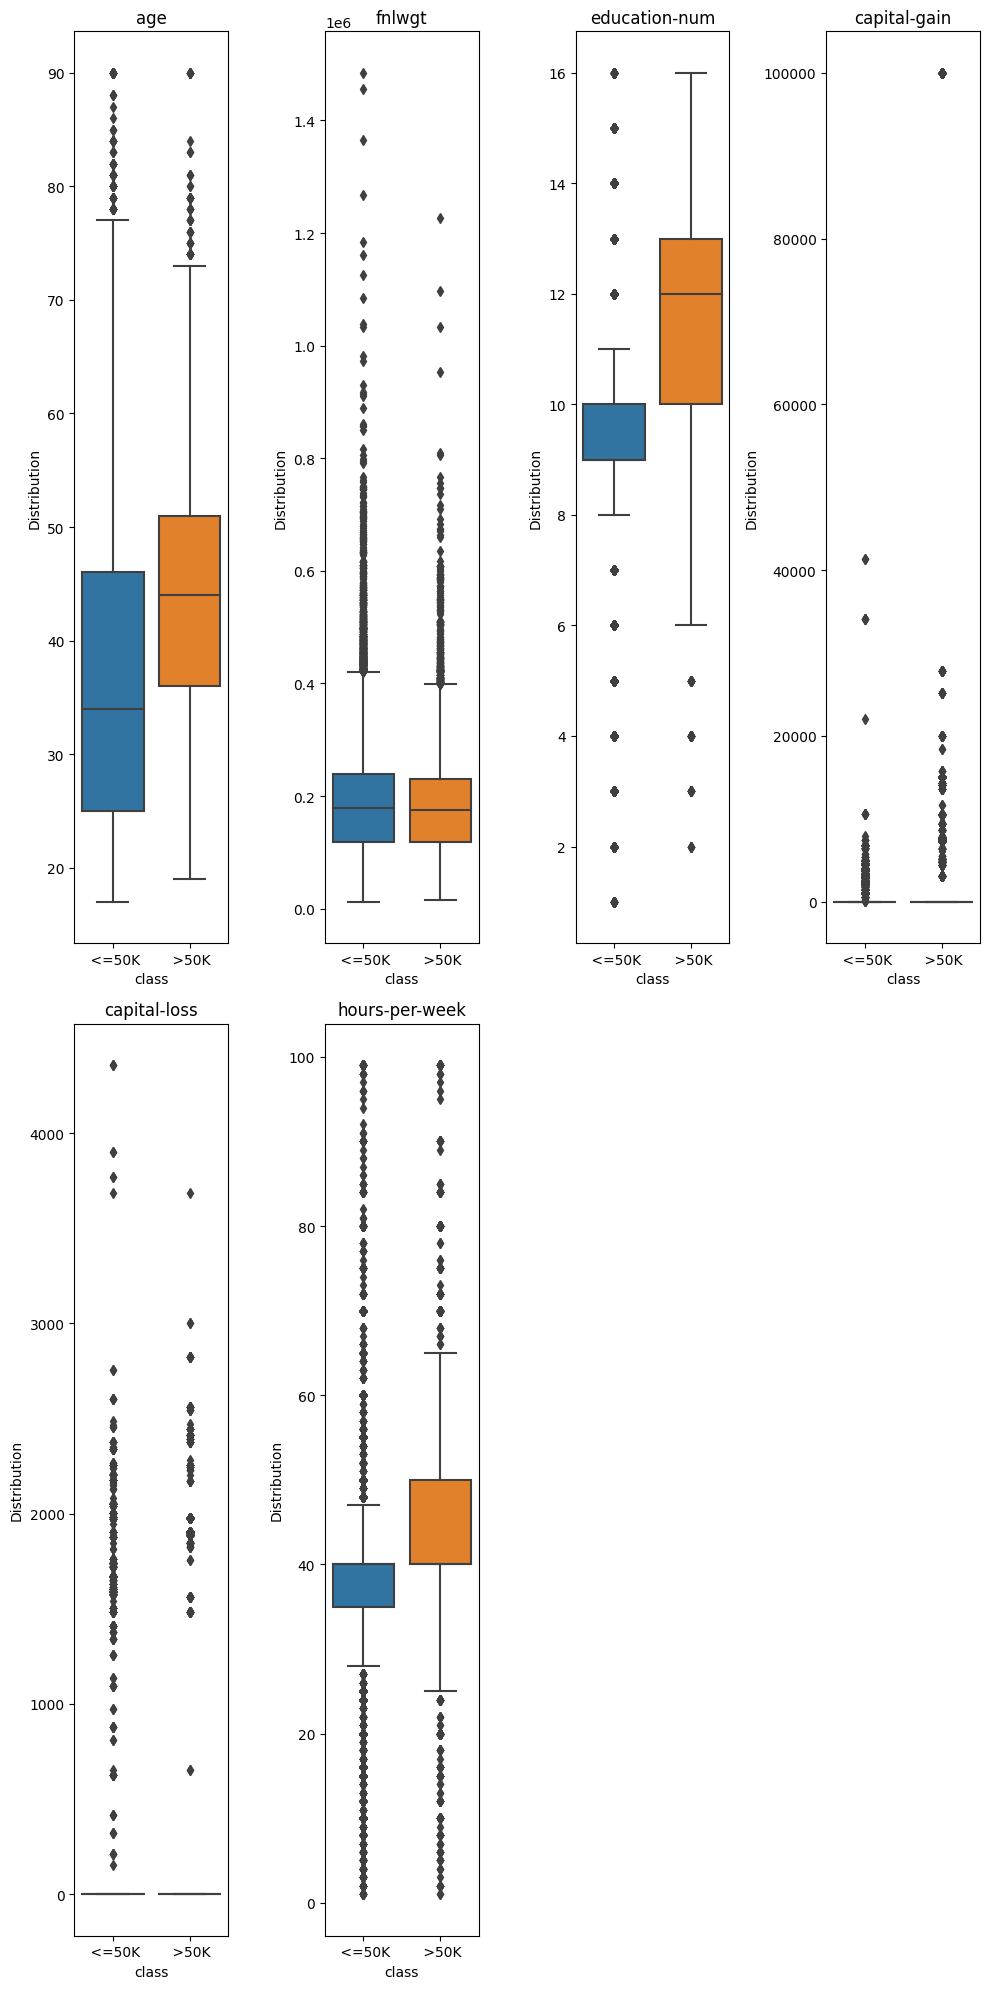

In [253]:
visualize_outliers(train)

This plot helps visualize the distribution of numerical features across different categories of the 'class' variable. It allows for a comparison of the central tendency, spread, and potential outliers in the numerical features for each category.

It can help identify differences or patterns in the distributions that may be indicative of outliers or variations between the categories.

In [254]:
def show_histogram(df1, num_cols=num_cols):
    cols = 4
    rows = len(num_cols) // cols + 1
    plt.figure(figsize=(10,20))
    for idx, feature in enumerate(num_cols):
        ax = plt.subplot(rows, cols, idx+1)
        sns.histplot(
            data=df1[feature], kde=True
        )

        ax.set_ylabel("count")

    plt.tight_layout()
    plt.show()

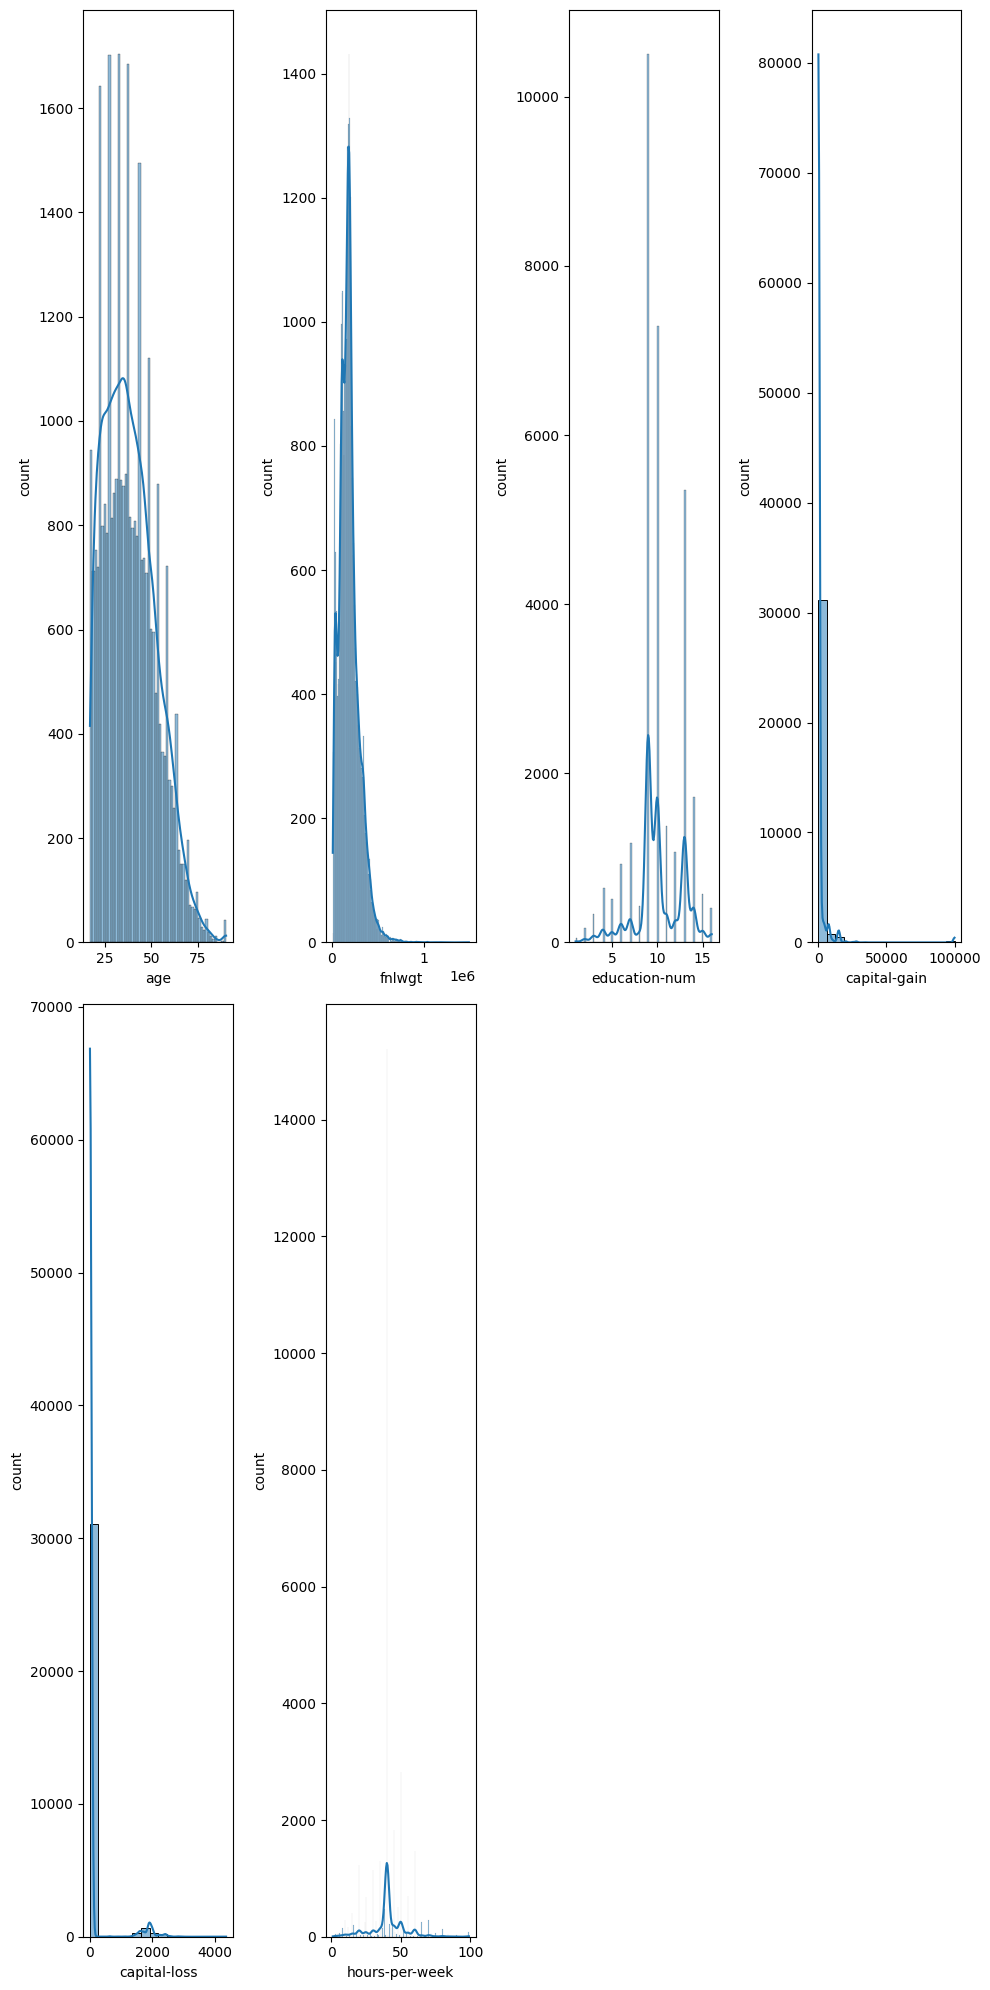

In [255]:
show_histogram(train)

This plot helps visualize the distribution of numerical features individually.

It provides insights into the shape, spread, and central tendency of each feature's distribution.

Histograms are useful for identifying patterns, skewness, or outliers in the data.

In [256]:
std_scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
quantile_scaler = preprocessing.QuantileTransformer(n_quantiles=60, output_distribution='uniform')

These scaler objects can be used to preprocess numerical data before feeding it into machine learning models. Each scaler has its own advantages and use cases, depending on the characteristics of the data and the requirements of the model.

In [257]:
scaled_train_df = train.copy(deep=True)
scaled_test_df = test.copy(deep=True)
scaled_train_df[num_cols] = quantile_scaler.fit_transform(scaled_train_df[num_cols])
scaled_test_df[num_cols] = quantile_scaler.fit_transform(scaled_test_df[num_cols])

The code scales the numerical columns in both the training and test DataFrames based on their quantile ranks.

This transformation can help normalize the distributions and make the data more suitable for certain modeling algorithms or analysis techniques.

# Check For Outliers

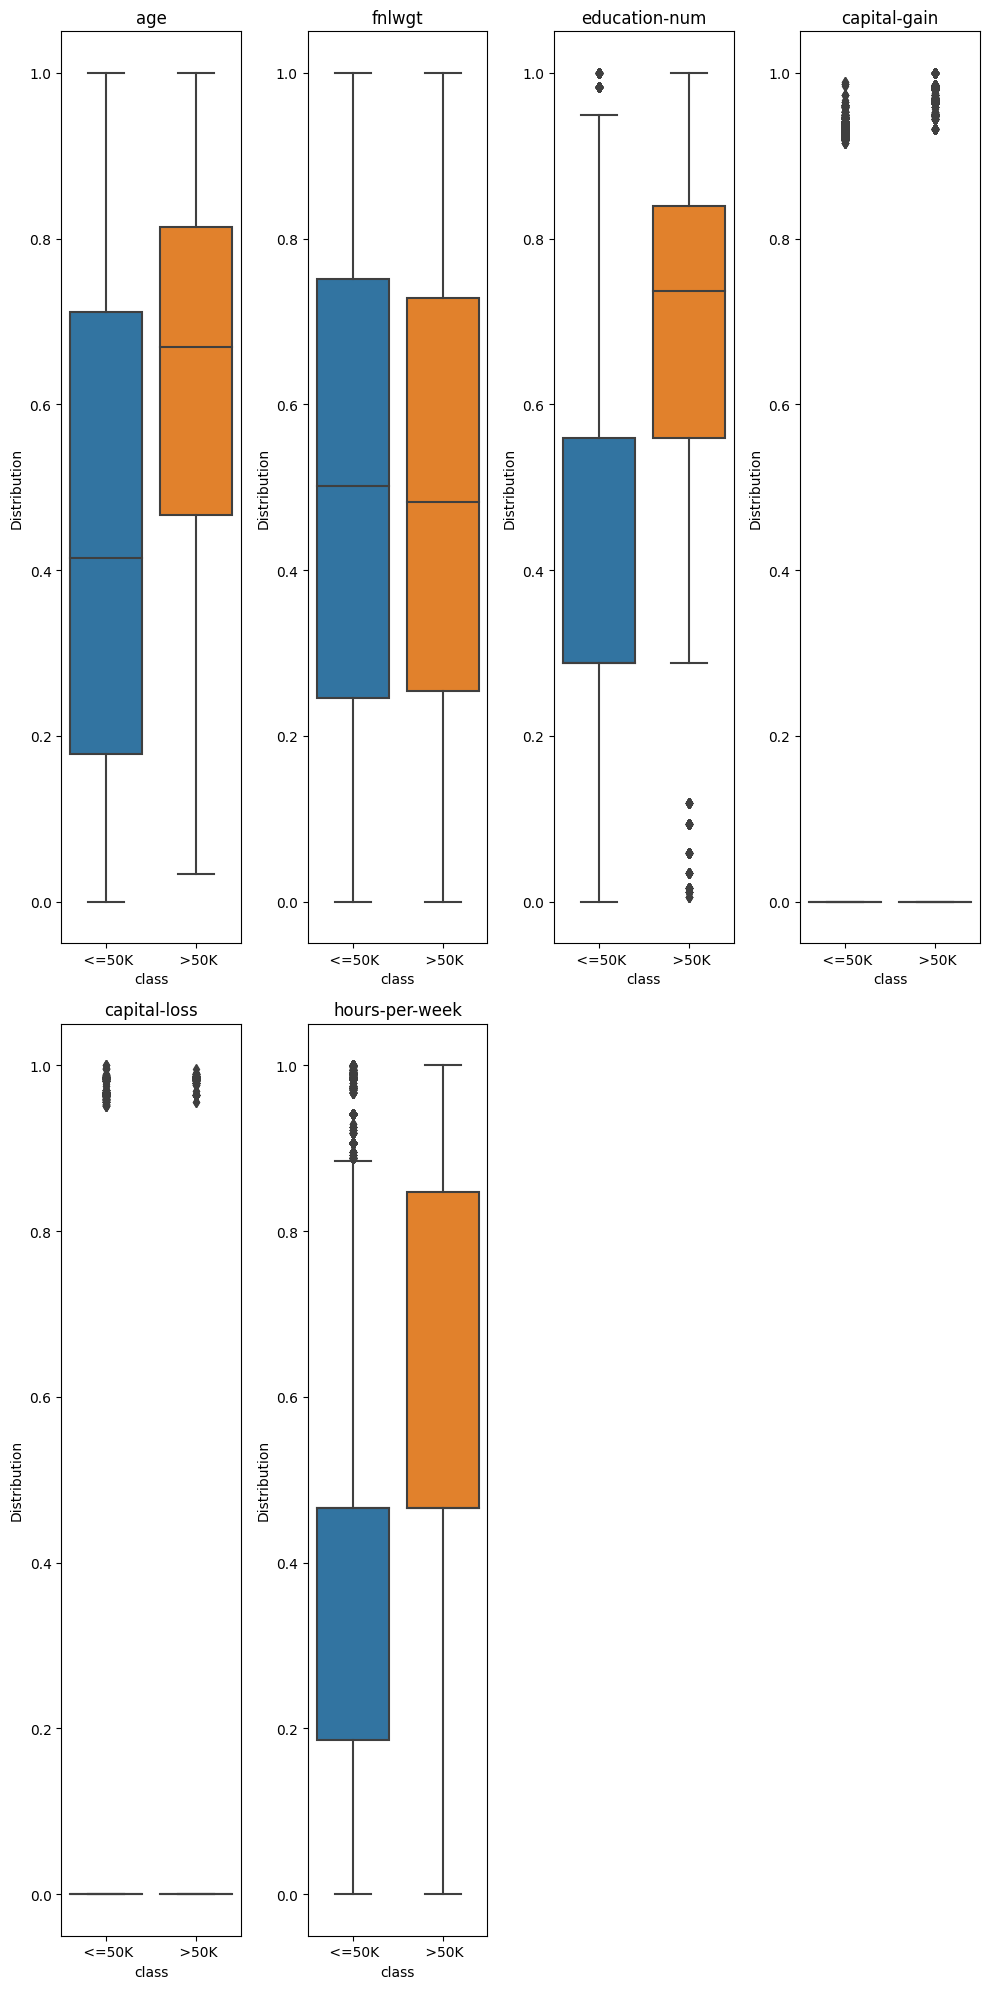

In [258]:
# check outliers in the scaled data
visualize_outliers(scaled_train_df)

# Check Histogram For Distributions

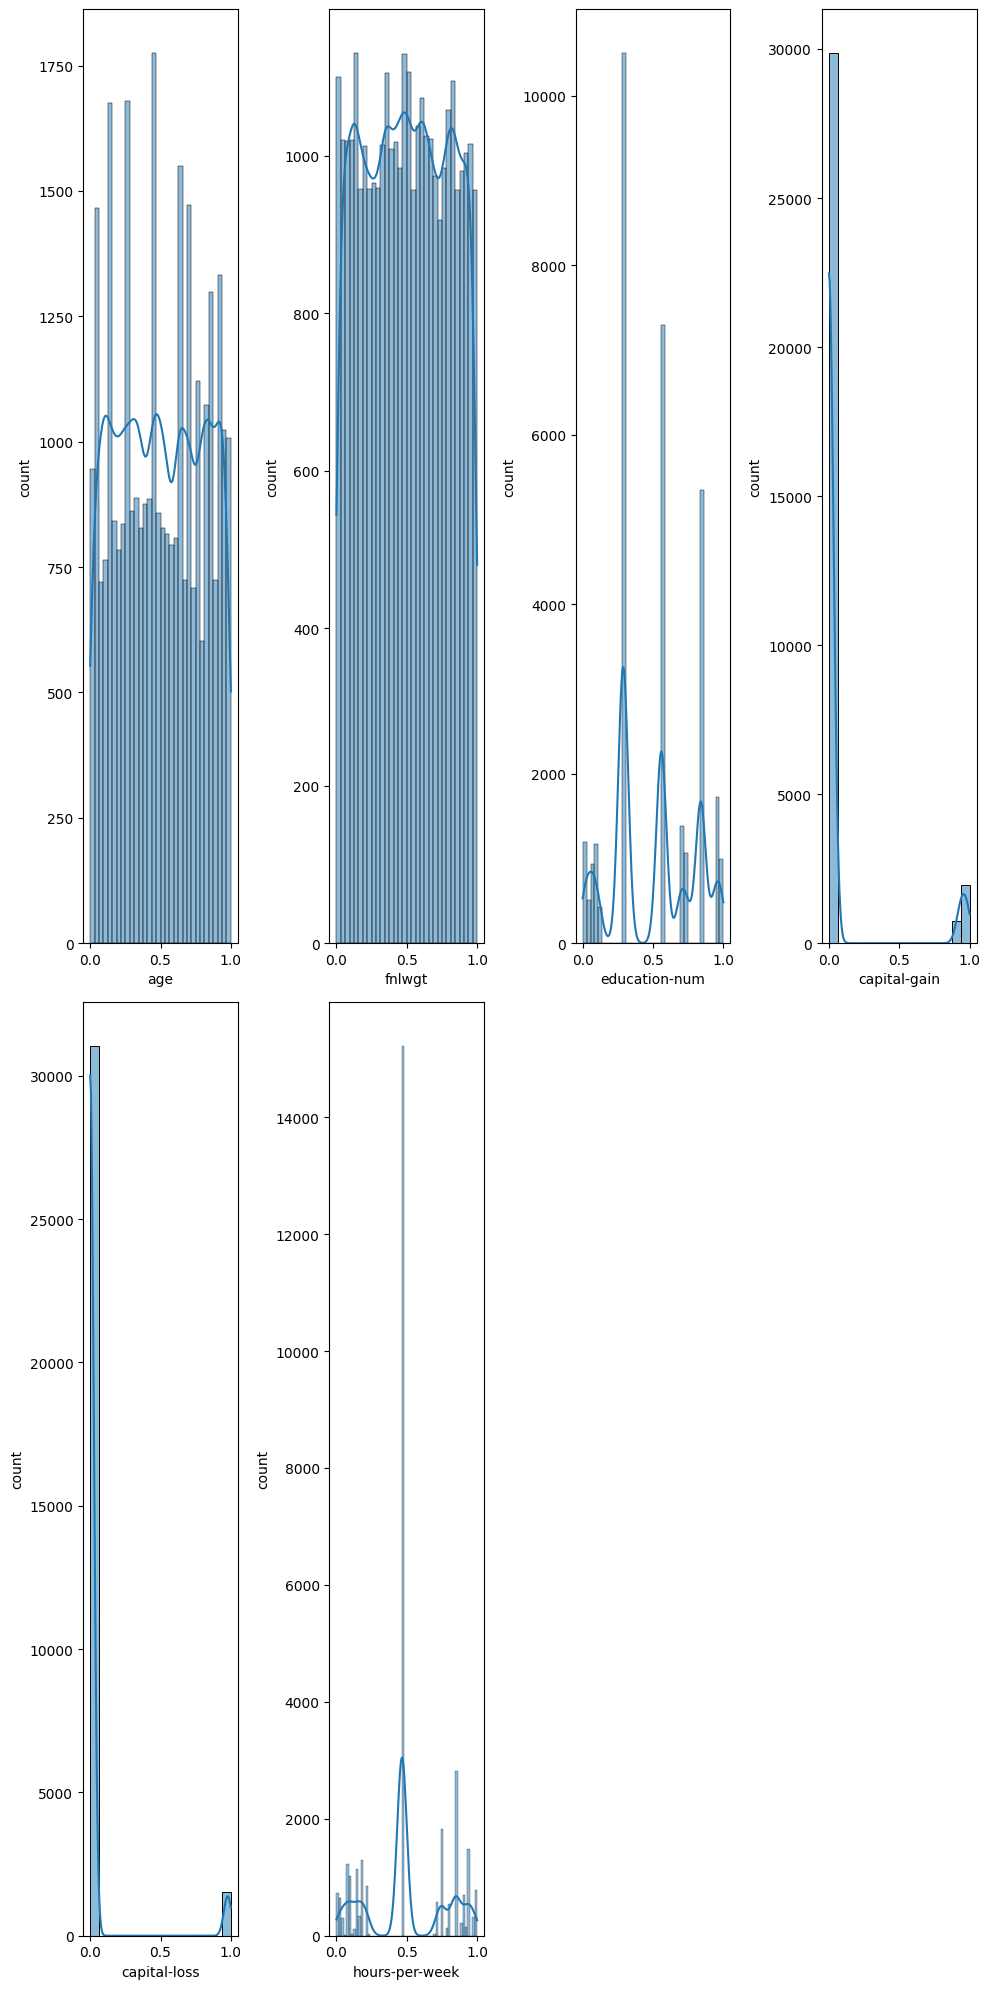

In [259]:
# check the histogram
show_histogram(scaled_train_df)

# Handle Odd Features That May Affect the Model

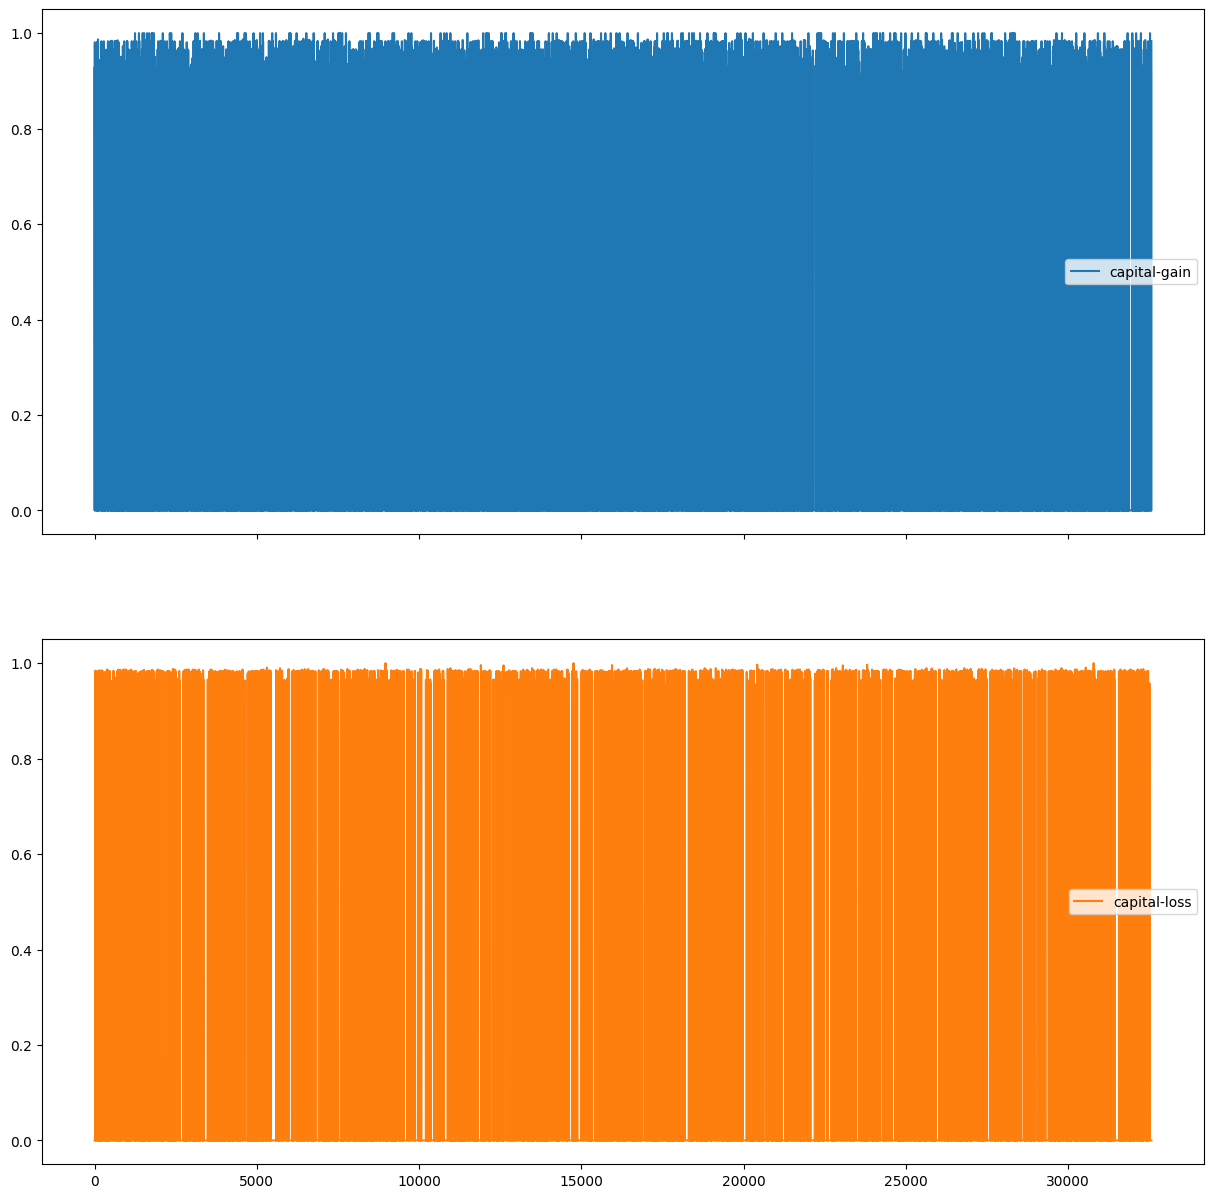

In [260]:
weird_features = ['capital-gain', 'capital-loss']
scaled_train_df[weird_features].plot(subplots=True, figsize=(15,15));

In [261]:
scaled_train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,0.542373,State-gov,0.117944,Bachelors,0.838983,Never-married,Adm-clerical,Not-in-family,White,Male,0.927129,0.0,0.466102,United-States,<=50K
1,0.796610,Self-emp-not-inc,0.128380,Bachelors,0.838983,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.027119,United-States,<=50K
2,0.516949,Private,0.679530,HS-grad,0.288136,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.466102,United-States,<=50K
3,0.847458,Private,0.739815,11th,0.093220,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.466102,United-States,<=50K
4,0.254237,Private,0.908509,Bachelors,0.838983,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.466102,Cuba,<=50K


# Data Manipulation

In [262]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

x = scaled_train_df.drop('class', axis = 1)
y = scaled_train_df[['class']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Identify categorical columns
categorical_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categorical columns in X_train
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

label_encoder = LabelEncoder()
# Concatenate numerical and encoded categorical columns
X_train_encoded = pd.concat([X_train.select_dtypes(include=np.number), X_train[categorical_cols]], axis=1)
X_test_encoded = pd.concat([X_test.select_dtypes(include=np.number), X_test[categorical_cols]], axis=1)

By performing this data preprocessing and encoding step, the code ensures that the categorical columns in the training and test data are converted into numerical labels.

This enables machine learning algorithms to process the data effectively. The numerical and encoded categorical features are then used for model training and evaluation.

In [263]:
imputer = SimpleImputer(strategy='median')  # You can choose different imputation strategies like 'mean', 'median', 'most_frequent', etc.

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

By using the SimpleImputer with the specified strategy, the code replaces missing values in the training and test data with the median of each respective column.

This helps in handling missing data and ensures that the imputed data is ready for further processing or model training.

# Build models

In [264]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.005, random_state=42, loss='log_loss')

# Support Vector Machine Classifier
svm_model = SVC(kernel='rbf', C=1.0, probability=True, gamma='scale', random_state=42)

cat_params = {
        'learning_rate': 0.005,
        'iterations': 50500,
        'depth': 4, #
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3, # 3, 30
        'random_seed': 4,
        'auto_class_weights': 'Balanced',
        'verbose' : 1000

    }
gbc = CatBoostClassifier(**cat_params)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [265]:
gb_model.fit(X_train, np.ravel(y_train))
svm_model.fit(X_train, np.ravel(y_train))
gbc.fit(X_train, np.ravel(y_train))
rf.fit(X_train, np.ravel(y_train))

0:	learn: 0.6897750	total: 9.78ms	remaining: 8m 13s
1000:	learn: 0.3734485	total: 9.44s	remaining: 7m 46s
2000:	learn: 0.3550329	total: 16.5s	remaining: 6m 39s
3000:	learn: 0.3414232	total: 26.1s	remaining: 6m 53s
4000:	learn: 0.3323062	total: 33.8s	remaining: 6m 32s
5000:	learn: 0.3255005	total: 42.7s	remaining: 6m 28s
6000:	learn: 0.3202214	total: 52.2s	remaining: 6m 27s
7000:	learn: 0.3154567	total: 59.3s	remaining: 6m 8s
8000:	learn: 0.3111496	total: 1m 8s	remaining: 6m 5s
9000:	learn: 0.3072218	total: 1m 17s	remaining: 5m 59s
10000:	learn: 0.3036725	total: 1m 25s	remaining: 5m 46s
11000:	learn: 0.3003147	total: 1m 37s	remaining: 5m 48s
12000:	learn: 0.2972532	total: 1m 46s	remaining: 5m 42s
13000:	learn: 0.2943090	total: 1m 54s	remaining: 5m 29s
14000:	learn: 0.2915519	total: 2m 3s	remaining: 5m 23s
15000:	learn: 0.2889148	total: 2m 11s	remaining: 5m 10s
16000:	learn: 0.2862732	total: 2m 20s	remaining: 5m 3s
17000:	learn: 0.2837256	total: 2m 30s	remaining: 4m 55s
18000:	learn: 0.2

RandomForestClassifier(random_state=42)

By calling the fit method on each model with the training data, the models are trained on the provided features and corresponding target values.

After this step, the models are ready to make predictions on new, unseen data using the learned patterns from the training phase.

In [266]:
gb_predictions = gb_model.predict_proba(X_test)
svm_predictions = svm_model.predict_proba(X_test)
cb_predictions = gbc.predict_proba(X_test)
rf_predictions = rf.predict_proba(X_test)

By calling the predict_proba method on each model with the test data, the models generate the probability estimates for each class.

These probability estimates can be used for various purposes such as evaluating model performance or making decisions based on the predicted probabilities.

In [267]:
# Soft Voting (combines predicted probabilities)
ensemble_model = VotingClassifier(estimators=[('gb', gb_model), ('svm', svm_model), ('cat', gbc), ('rf', rf)], voting='soft')

By creating an ensemble model with soft voting, the code combines the predicted probabilities from multiple individual models to make a final prediction.

The ensemble model takes advantage of the collective knowledge of the individual models to potentially improve overall prediction performance.

In [268]:
ensemble_model.fit(X_train, np.ravel(y_train))

0:	learn: 0.6897750	total: 7.68ms	remaining: 6m 27s
1000:	learn: 0.3734485	total: 10s	remaining: 8m 16s
2000:	learn: 0.3550329	total: 18s	remaining: 7m 15s
3000:	learn: 0.3414232	total: 26.6s	remaining: 7m 1s
4000:	learn: 0.3323062	total: 36.4s	remaining: 7m 2s
5000:	learn: 0.3255005	total: 43.6s	remaining: 6m 36s
6000:	learn: 0.3202214	total: 53.4s	remaining: 6m 35s
7000:	learn: 0.3154567	total: 1m 6s	remaining: 6m 55s
8000:	learn: 0.3111496	total: 1m 18s	remaining: 6m 55s
9000:	learn: 0.3072218	total: 1m 33s	remaining: 7m 11s
10000:	learn: 0.3036725	total: 1m 41s	remaining: 6m 52s
11000:	learn: 0.3003147	total: 1m 55s	remaining: 6m 55s
12000:	learn: 0.2972532	total: 2m 9s	remaining: 6m 56s
13000:	learn: 0.2943090	total: 2m 19s	remaining: 6m 42s
14000:	learn: 0.2915519	total: 2m 29s	remaining: 6m 29s
15000:	learn: 0.2889148	total: 2m 36s	remaining: 6m 10s
16000:	learn: 0.2862732	total: 2m 47s	remaining: 6m 1s
17000:	learn: 0.2837256	total: 2m 56s	remaining: 5m 47s
18000:	learn: 0.2812

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(learning_rate=0.005,
                                                         random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7e616d42b370>),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

Fitting combined models.

# Testing

In [269]:
ensemble_predictions = ensemble_model.predict_proba(X_test)

Predicting using test data.

In [270]:
# Generate thresholds
num_thresholds = 100
thresholds = np.linspace(0, 1, num_thresholds)

# Initialize variables for optimal threshold and corresponding metric
best_f1 = 0
optimal_threshold = 0

# Iterate over thresholds and compute evaluation metrics
y_testB = np.where(y_test['class'] == ' >50K', 1, 0)
j = 0
for threshold in thresholds:
    # Convert probabilities into class labels based on threshold
    predicted_labels = np.where(np.array(ensemble_predictions) >= threshold, 1, 0)

    # Calculate evaluation metric (e.g., F1-score) using the true labels (y_test) and predicted labels
    f1 = f1_score(y_testB, predicted_labels[:, 1])
    j += 1
    # Update optimal threshold and metric if a higher F1-score is achieved
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1-score:", best_f1)


Optimal Threshold: 0.4141414141414142
Best F1-score: 0.7280150753768844


The code iterates over different thresholds and computes the F1-score for each threshold.

It finds the optimal threshold that maximizes the F1-score and prints the corresponding threshold and the best F1-score achieved.

In [271]:
gb_accuracy = accuracy_score(y_testB, np.where(gb_predictions[:, 1] > optimal_threshold, 1, 0))
svm_accuracy = accuracy_score(y_testB, np.where(svm_predictions[:, 1] > optimal_threshold, 1, 0))
cat_accuracy = accuracy_score(y_testB, np.where(cb_predictions[:, 1] > optimal_threshold, 1, 0))
rf_accuracy = accuracy_score(y_testB, np.where(rf_predictions[:, 1] > optimal_threshold, 1, 0))
ensemble_accuracy = accuracy_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

print("Gradient Boosting Accuracy:", gb_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("CatBoost Accuracy:", cat_accuracy)
print("Rf Accuracy:", rf_accuracy)
print("Ensemble Accuracy:", ensemble_accuracy)

Gradient Boosting Accuracy: 0.8057730692461231
SVM Accuracy: 0.8165208045447566
CatBoost Accuracy: 0.8232765238753262
Rf Accuracy: 0.8572086596038692
Ensemble Accuracy: 0.8670351604483341


Gradient Boosting Accuracy: 0.8057730692461231

The Gradient Boosting model achieves an accuracy of approximately 80.58% on the test data. It performs moderately well in predicting the target variable.

SVM Accuracy: 0.8165208045447566

The Support Vector Machine (SVM) model achieves an accuracy of approximately 81.65% on the test data. It performs slightly better than the Gradient Boosting model in terms of accuracy.

CatBoost Accuracy: 0.8232765238753262

The CatBoost model achieves an accuracy of approximately 82.33% on the test data. It performs better than both the Gradient Boosting and SVM models in terms of accuracy.

Random Forest Accuracy: 0.8572086596038692

The Random Forest model achieves an accuracy of approximately 85.72% on the test data. It outperforms the previous three models in terms of accuracy.

Ensemble Accuracy: 0.8670351604483341

The Ensemble model, which combines the predictions of multiple models using soft voting, achieves an accuracy of approximately 86.70% on the test data. It performs better than all individual models in terms of accuracy.

### Accuracy alone may not provide a complete picture of model performance, and other evaluation metrics should be considered as well

In [272]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

precision = precision_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
recall = recall_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
f1 = f1_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
auroc = roc_auc_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUROC Score:', auroc)

Precision: 0.7185368877867327
Recall: 0.7377466581795035
F1 Score: 0.7280150753768844
AUROC Score: 0.8229405083693955


Precision: 0.7185368877867327

Precision is a measure of the model's ability to correctly identify positive instances out of all instances predicted as positive. In this case, the precision score of approximately 0.72 indicates that when the model predicts a positive outcome, it is correct around 72% of the time.

Recall: 0.7377466581795035

Recall (also known as sensitivity or true positive rate) measures the model's ability to correctly identify positive instances out of all actual positive instances. The recall score of approximately 0.74 suggests that the model can capture around 74% of the actual positive instances.

F1 Score: 0.7280150753768844

The F1 score is the harmonic mean of precision and recall, providing a balanced measure of a model's performance. With an F1 score of approximately 0.73, the model achieves a reasonable balance between precision and recall.

AUROC Score: 0.8229405083693955

AUROC (Area Under the Receiver Operating Characteristic Curve) is a measure of the model's ability to distinguish between positive and negative instances across different probability thresholds. The AUROC score of approximately 0.82 indicates a good level of discrimination ability for the model.

### The specific context and requirements of the problem at hand when interpreting these metrics. For example, depending on the specific application, precision or recall might be of higher importance. Therefore, it's recommended to consider these metrics along with other domain-specific considerations to assess the model's effectiveness.

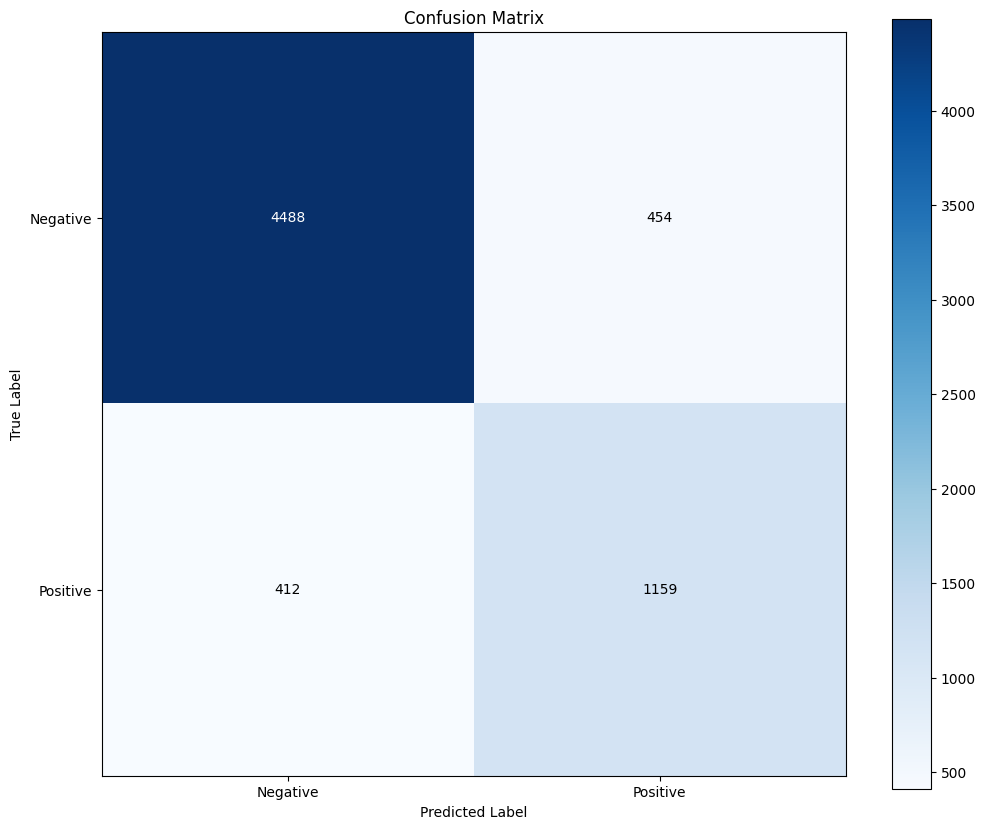

In [273]:
# Calculate confusion matrix
cm = confusion_matrix(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Define class labels
class_labels = ['Negative', 'Positive']

# Create labeled confusion matrix plot
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The plot visually represents the confusion matrix, which provides insights into the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

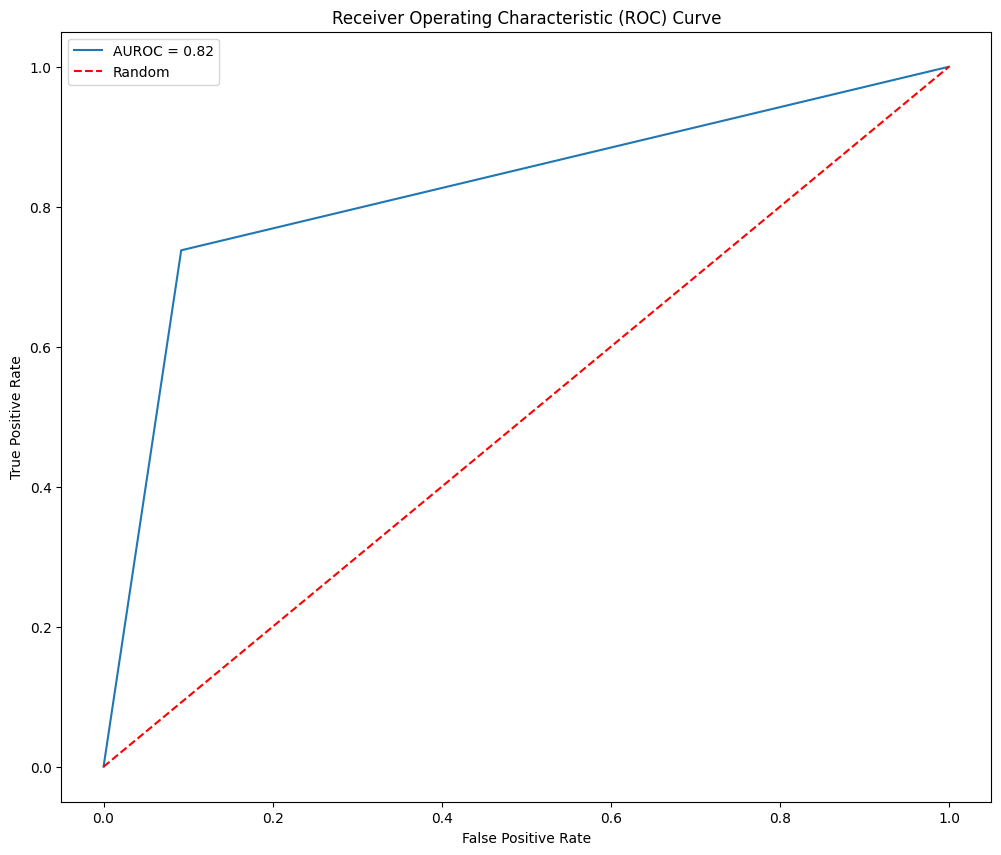

In [274]:
# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted scores or probabilities
fpr, tpr, thresholds = roc_curve(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Calculate the AUROC score
auroc = roc_auc_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The resulting plot shows the ROC curve, which visualizes the trade-off between the true positive rate and the false positive rate at different classification thresholds.

The AUROC score is displayed as a label on the plot, providing a single metric to summarize the overall performance of the classifier. The dashed line represents the ROC curve of a random classifier, serving as a reference for comparison.

With a score of 0.82 we can assume that the modekl performs very well, but depending on the problem and data set other methods may prove better.

# Overall Summary

Data Preprocessing:

The code includes preprocessing steps such as scaling, encoding categorical variables, and imputing missing values using different techniques like StandardScaler, QuantileTransformer, LabelEncoder, and SimpleImputer. These steps aim to prepare the data for modeling and ensure it is in a suitable format for the machine learning algorithms.
Model Training:

Several classification models are used, including Gradient Boosting, Support Vector Machine (SVM), CatBoost, and Random Forest. These models are fitted on the preprocessed training data using the fit method.
Ensemble Model:

An ensemble model is created using the VotingClassifier, which combines the predictions from multiple base models (Gradient Boosting, SVM, CatBoost, and Random Forest) using a soft voting strategy.
Model Evaluation:

Various evaluation metrics are calculated to assess the performance of the models. These metrics include accuracy, precision, recall, F1 score, and AUROC score.
Confusion Matrix:

The confusion matrix is visualized to provide insights into the model's performance in terms of true positives, true negatives, false positives, and false negatives.
ROC Curve:

The ROC curve is plotted to illustrate the trade-off between true positive rate and false positive rate at different classification thresholds. The AUROC score is calculated as a summary metric for the ROC curve, indicating the model's ability to distinguish between positive and negative samples.
Based on the provided results, it appears that the ensemble model achieved the highest accuracy, followed by Random Forest, CatBoost, SVM, and Gradient Boosting. The ensemble model's superior performance suggests that combining the predictions from multiple models can lead to improved classification results. Additionally, the F1 score and AUROC score provide insights into the model's precision, recall, and overall discriminative ability.

# Conclusion

It can be concluded that the Ensemble model outperforms the individual models (Random Forest, CatBoost, SVM, and Gradient Boosting) in terms of accuracy, precision, recall, F1 score, and AUROC score. It shows a good balance between correctly identifying positive instances and avoiding false positives.

Therefore, the Ensemble model can be considered the most effective model for this classification task.